In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/04%20Deep%20Learning/data/auto-mpg.data"

df = pd.read_csv(url,
                header=0,
                index_col=0,
                na_values = "?",
                comment='\t',
                skipinitialspace=True)

df = df.dropna()
df = pd.get_dummies(data=df,columns=['Origin'],
                       drop_first=True,dtype=int)
df.rename(columns={'Origin_2':'Europe',
                   'Origin_3':'Japan'},
             inplace=True)
display(df)

X = df.iloc[:,1:].values
y = df['MPG'].values

print(f"Shapes de X y y: {X.shape}, {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.85,random_state=189)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")



scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
391,36.0,4,135.0,84.0,2370.0,13.0,82,0,0
392,27.0,4,151.0,90.0,2950.0,17.3,82,0,0
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0


Shapes de X y y: (390, 8), (390,)
Train size: 331
Test size: 59


In [53]:
np.random.seed(189)
tf.random.set_seed(189)

def build_and_evaluate_model(layers_config, activation, optimizer, learning_rate, X_train, y_train, X_test, y_test, epochs=100):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for neurons in layers_config:
        model.add(layers.Dense(neurons, activation=activation))
    
    model.add(layers.Dense(1, activation=None))
    
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0)
    loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
    
    return mae

# Configuraciones de hiperparámetros a probar
layer_configs = [
    [32, 32],
    [64, 64],
    [64, 32, 16],
    [128, 64, 32],
    [128, 128, 64, 32]
]

activations = ['relu', 'tanh']
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop]
learning_rates = [0.001, 0.01]

# Realizar la búsqueda de hiperparámetros
results = []
for layers_config in layer_configs:
    for activation in activations:
        for optimizer in optimizers:
            for lr in learning_rates:
                mae = build_and_evaluate_model(layers_config, activation, optimizer, lr, X_train_scl, y_train, X_test_scl, y_test)
                results.append({
                    'layers': layers_config,
                    'activation': activation,
                    'optimizer': optimizer.__name__,
                    'learning_rate': lr,
                    'mae': mae
                })
                print(f"Config: layers={layers_config}, activation={activation}, optimizer={optimizer.__name__}, lr={lr}, MAE={mae}")

# Encontrar la mejor configuración
best_result = min(results, key=lambda x: x['mae'])
print(f"Best Configuration: {best_result}")

Config: layers=[32, 32], activation=relu, optimizer=Adam, lr=0.001, MAE=2.1808018684387207
Config: layers=[32, 32], activation=relu, optimizer=Adam, lr=0.01, MAE=1.8311431407928467
Config: layers=[32, 32], activation=relu, optimizer=RMSprop, lr=0.001, MAE=2.062091588973999
Config: layers=[32, 32], activation=relu, optimizer=RMSprop, lr=0.01, MAE=2.5730366706848145
Config: layers=[32, 32], activation=tanh, optimizer=Adam, lr=0.001, MAE=3.4186670780181885
Config: layers=[32, 32], activation=tanh, optimizer=Adam, lr=0.01, MAE=1.8778306245803833
Config: layers=[32, 32], activation=tanh, optimizer=RMSprop, lr=0.001, MAE=3.272063732147217
Config: layers=[32, 32], activation=tanh, optimizer=RMSprop, lr=0.01, MAE=2.186235189437866
Config: layers=[64, 64], activation=relu, optimizer=Adam, lr=0.001, MAE=2.000767230987549
Config: layers=[64, 64], activation=relu, optimizer=Adam, lr=0.01, MAE=1.9216843843460083
Config: layers=[64, 64], activation=relu, optimizer=RMSprop, lr=0.001, MAE=1.8544485569

In [8]:
np.random.seed(189)
tf.random.set_seed(189)

def best_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scl.shape[1],)))
    model.add(layers.Dense(32, activation= 'relu'))
    model.add(layers.Dense(32, activation= 'relu'))
    model.add(layers.Dense(1, activation=None))

    optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model_best = best_model()

history = model_best.fit(X_train_scl, y_train, epochs=100, validation_split=0.2, verbose=0)
loss, mae, mse = model_best.evaluate(X_test_scl, y_test, verbose=0)
print("MAE: ", mae)
y_pred = model_best.predict(X_test_scl).flatten()
    

MAE:  1.7918267250061035
2/2 [==============================] - 0s 2ms/step


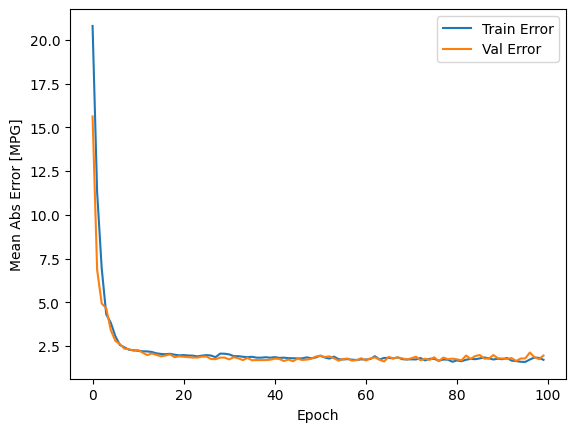

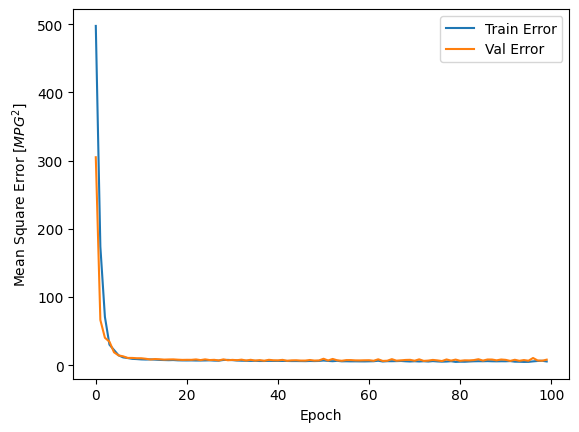

In [11]:
# def plot_history(history):
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')
plt.plot(history.epoch, history.history['mae'],
        label='Train Error')
plt.plot(history.epoch, history.history['val_mae'],
        label = 'Val Error')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(history.epoch, history.history['mse'],
        label='Train Error')
plt.plot(history.epoch, history.history['val_mse'],
        label = 'Val Error')
plt.legend()
plt.show()

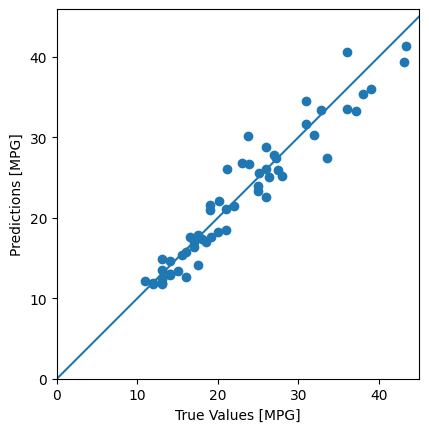

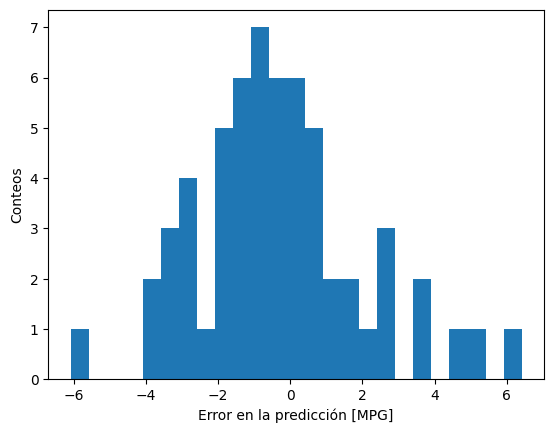

In [9]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Error en la predicción [MPG]")
plt.ylabel("Conteos")
plt.show()

In [7]:
df_new = pd.read_csv('mpg_new_data.csv')
df_new = df_new.drop(columns=['Origin', 'Unnamed: 0'])
df_new['Europa'] = [0, 0]
df_new['Japan'] = [0, 0]

df_new_scl = scaler.fit_transform(df_new)
print(df_new)
df_pred = model_best.predict(df_new_scl).flatten()

df_new['MPG'] = np.round(y_pred)
df.to_csv('mpg_new_pred_data.csv', index=False)
df_new

   Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0          4           120          79    2625          18.6          82   
1          4           119          82    2720          19.4          82   

   Europa  Japan  
0       0      0  
1       0      0  
1/1 [==============================] - 0s 28ms/step


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europa,Japan,MPG
0,4,120,79,2625,18.6,82,0,0,25.0
1,4,119,82,2720,19.4,82,0,0,12.0
